In [1]:
#import pystan nevermind no general interpolation function
import pymc3 as pm
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import splat
from scipy import interpolate
import theano.tensor as tt
from theano.compile.ops import as_op
from scipy.interpolate import griddata
import wisps
import theano

### Purpose: Make UCD evolutionary models interpolations in pymc

**Towards a full Bayesian hierchical modelling of UCD mass function**

Rough graphical model
- $\alpha$ ~ Uniform
- M &larr; Powerlaw($\alpha$)
- Age ~ Uniform
- Teff &larr; (M, Age)
- SpT &larr; Teff
- $\phi$ &larr; SpT, V


In [2]:
#modelfile='../splines.stan'
datafile='/users/caganze/desktop/burrows2001.csv'
burrows=pd.read_csv(datafile)

In [10]:
@as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix])
def custom_interpolation_mass_age(mass, age):
    """
    Interpolation function using burrow's models and scipy interpolate
    All this wrapped in theano tensors 
    
    Input: mass, age
    Output: teff
    """
    points=np.array([burrows.mass.values, burrows.age.values]).T
    valuest=burrows.temperature.values
    valueslogg=burrows.gravity.values
    teff = griddata(points,valuest , (mass, age), method='linear')
    logg = griddata(points,valueslogg , (mass, age), method='linear')
    return  np.matrix([teff, logg]).astype("float64").T

#@as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])
def splat_teff_to_spt(teff):
    """
    Interpolatiom function using the Pecaut relation
    Input: teff
    Output: SpT
    """
    rel=splat.SPT_TEFF_RELATIONS['pecaut']
    spt_sorted_idx=np.argsort(rel['values'])
    return np.interp(teff, np.array(rel['values'])[spt_sorted_idx], np.array(rel['spt'])[spt_sorted_idx])

In [4]:
def galaxy_density_function(r, z, h=300.):
    
    """
    A custom juric density function that only uses numpy arrays for speed
    All units are in pc
    """
    l = 2600. # radial length scale of exponential thin disk 
    
    zpart=(1./np.cosh(abs(z-Zsun)/(2*h)))**2
    rpart=np.exp(-(r-Rsun)/h)
    return zpart*rpart

def logpdistance(r, z, d):
    return np.log((d**2)*density_function(r, z, h))
    
def logpmass(m, alpha):
    #a boring powerlaw
    return np.log(np.power(m, -alpha))


In [5]:
def phi(teffs):
    #return luminosity function in a given temperature range 
    #scaled to davy kirkpatrick 2019
    #return luminosity
    pass

In [6]:
with pm.Model() as model:

    alpha=pm.Uniform('alpha', lower=-1, upper=1)
    
    m=pm.Uniform('m', lower=np.nanmin(burrows.mass.values), upper=0.1)
    
    age=pm.Uniform('age', lower=np.nanmin(burrows.age.values), upper=np.nanmax(burrows.age.values))
    
    tefflogg=pm.Deterministic('tg', custom_interpolation_mass_age(m, age))  
    
    like = pm.DensityDist('like', logpmass, observed={'m': m, 'alpha': alpha})
    
    #phi=pm.Deterministic
    
   # N=Deterministic('N', phi*)
    
    trace = pm.sample(draws=1000, cores=2, step=pm.Metropolis())
    
    
    



Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [age]
>Metropolis: [m]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:26<00:00, 113.00draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [7]:
np.concatenate(trace.tg, axis=1)

array([[ 220.9522457 ,  217.33939107, 1148.74526062, ..., 1319.96227802,
        2152.37697827, 2806.1542668 ],
       [   4.31277282,    4.31368138,    5.41618845, ...,    5.49963793,
           5.39792479,    5.31215709]])

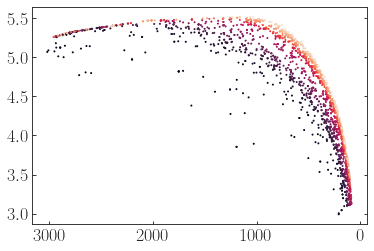

In [8]:
plt.scatter(np.concatenate(trace.tg[:,0]), np.concatenate(trace.tg[:,1]), c=trace.age, s=1.)
plt.gca().invert_xaxis()

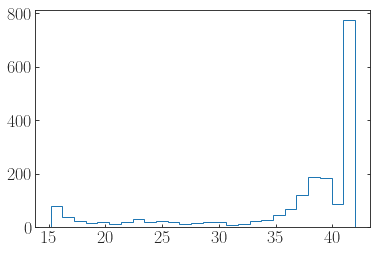

In [11]:
h=plt.hist(splat_teff_to_spt(np.concatenate(trace.tg[:,0])), histtype='step', bins='auto')